## BIO322 MINI PROJECT A (Thomas Castiglione)


**1. Exploration**


We first load and take a look at the training data:

In [60]:
data.full<-na.omit(read.csv(file.path("../data/training_data.csv")))

In [61]:
head(data.full)
dim(data.full)
#plot(sort(data$VALENCE.PLEASANTNESS))
#plot(sort(data$MW),data$VALENCE.PLEASANTNESS, xlab='MW')
#plot(as.factor(data$SWEETORSOUR),data$VALENCE.PLEASANTNESS,xlab='SWEETORSOUR')


,Intensity,VALENCE.PLEASANTNESS,SWEETORSOUR,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
,<chr>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,low,45,FALSE,302.0,208.33,5.952,19.698,34.491,21.523,39.571,...,0,0,1,0,1,0,1,0,1,0
2,high,49,TRUE,72.6,122.18,6.431,11.349,18.745,12.261,21.285,...,0,0,0,0,0,0,0,0,0,0
3,high,56,TRUE,259.0,242.29,7.572,20.832,32.167,21.693,35.535,...,0,0,1,0,1,1,1,0,1,1
4,high,7,FALSE,56.6,88.12,6.294,7.537,14.189,7.955,16.080,...,0,0,0,0,0,0,0,0,0,0
5,low,51,FALSE,84.7,136.21,6.191,12.876,21.629,14.023,24.701,...,0,0,0,0,0,0,0,0,0,0
6,high,21,FALSE,160.0,192.28,6.409,17.644,29.723,19.000,33.740,...,0,0,0,0,1,0,1,0,1,0


[1]  708 4872

to get the same type for all predictors(integers and/or decimals), we are going to transforme the predictors "Intensity" and "SWEETORSOUR" as integers
(for intensity, create new predictors for "high" and "low" with values 0 or 1 (one-hot-coding) and for SWEETORSOUR, True->1, False->0)

In [62]:
data.full$Intensity_high<-ifelse(data.full$Intensity=='high',1,0)
data.full$Intensity_low<-ifelse(data.full$Intensity=='low',1,0)
data.full$SWEETORSOUR <-as.integer(data$SWEETORSOUR)
data.full<-data.full[,-which(colnames(data.full)=='Intensity')]

In [63]:
head(data.full)

,VALENCE.PLEASANTNESS,SWEETORSOUR,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,...,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50,Intensity_high,Intensity_low
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,45,0,302.0,208.33,5.952,19.698,34.491,21.523,39.571,0.563,...,1,0,1,0,1,0,1,0,0,1
2,49,1,72.6,122.18,6.431,11.349,18.745,12.261,21.285,0.597,...,0,0,0,0,0,0,0,0,1,0
3,56,1,259.0,242.29,7.572,20.832,32.167,21.693,35.535,0.651,...,1,0,1,1,1,0,1,1,1,0
4,7,0,56.6,88.12,6.294,7.537,14.189,7.955,16.080,0.538,...,0,0,0,0,0,0,0,0,1,0
5,51,0,84.7,136.21,6.191,12.876,21.629,14.023,24.701,0.585,...,0,0,0,0,0,0,0,0,0,1
6,21,0,160.0,192.28,6.409,17.644,29.723,19.000,33.740,0.588,...,0,0,1,0,1,0,1,0,1,0


Now let's check if there is predictors with value 0 for all samples:

In [64]:
dim(data.full[,apply(data.full,2,function(x) all(x==0))])[2]

[1] 1840

There is 1840 predictors that are always 0, so we can remove them (they cannot have any impact on the VALENCE.PLEASANTNESS values)

In [65]:
data<-(data.full[,apply(data.full,2,function(x)!all(x==0))])
dim(data)[2]

[1] 3033

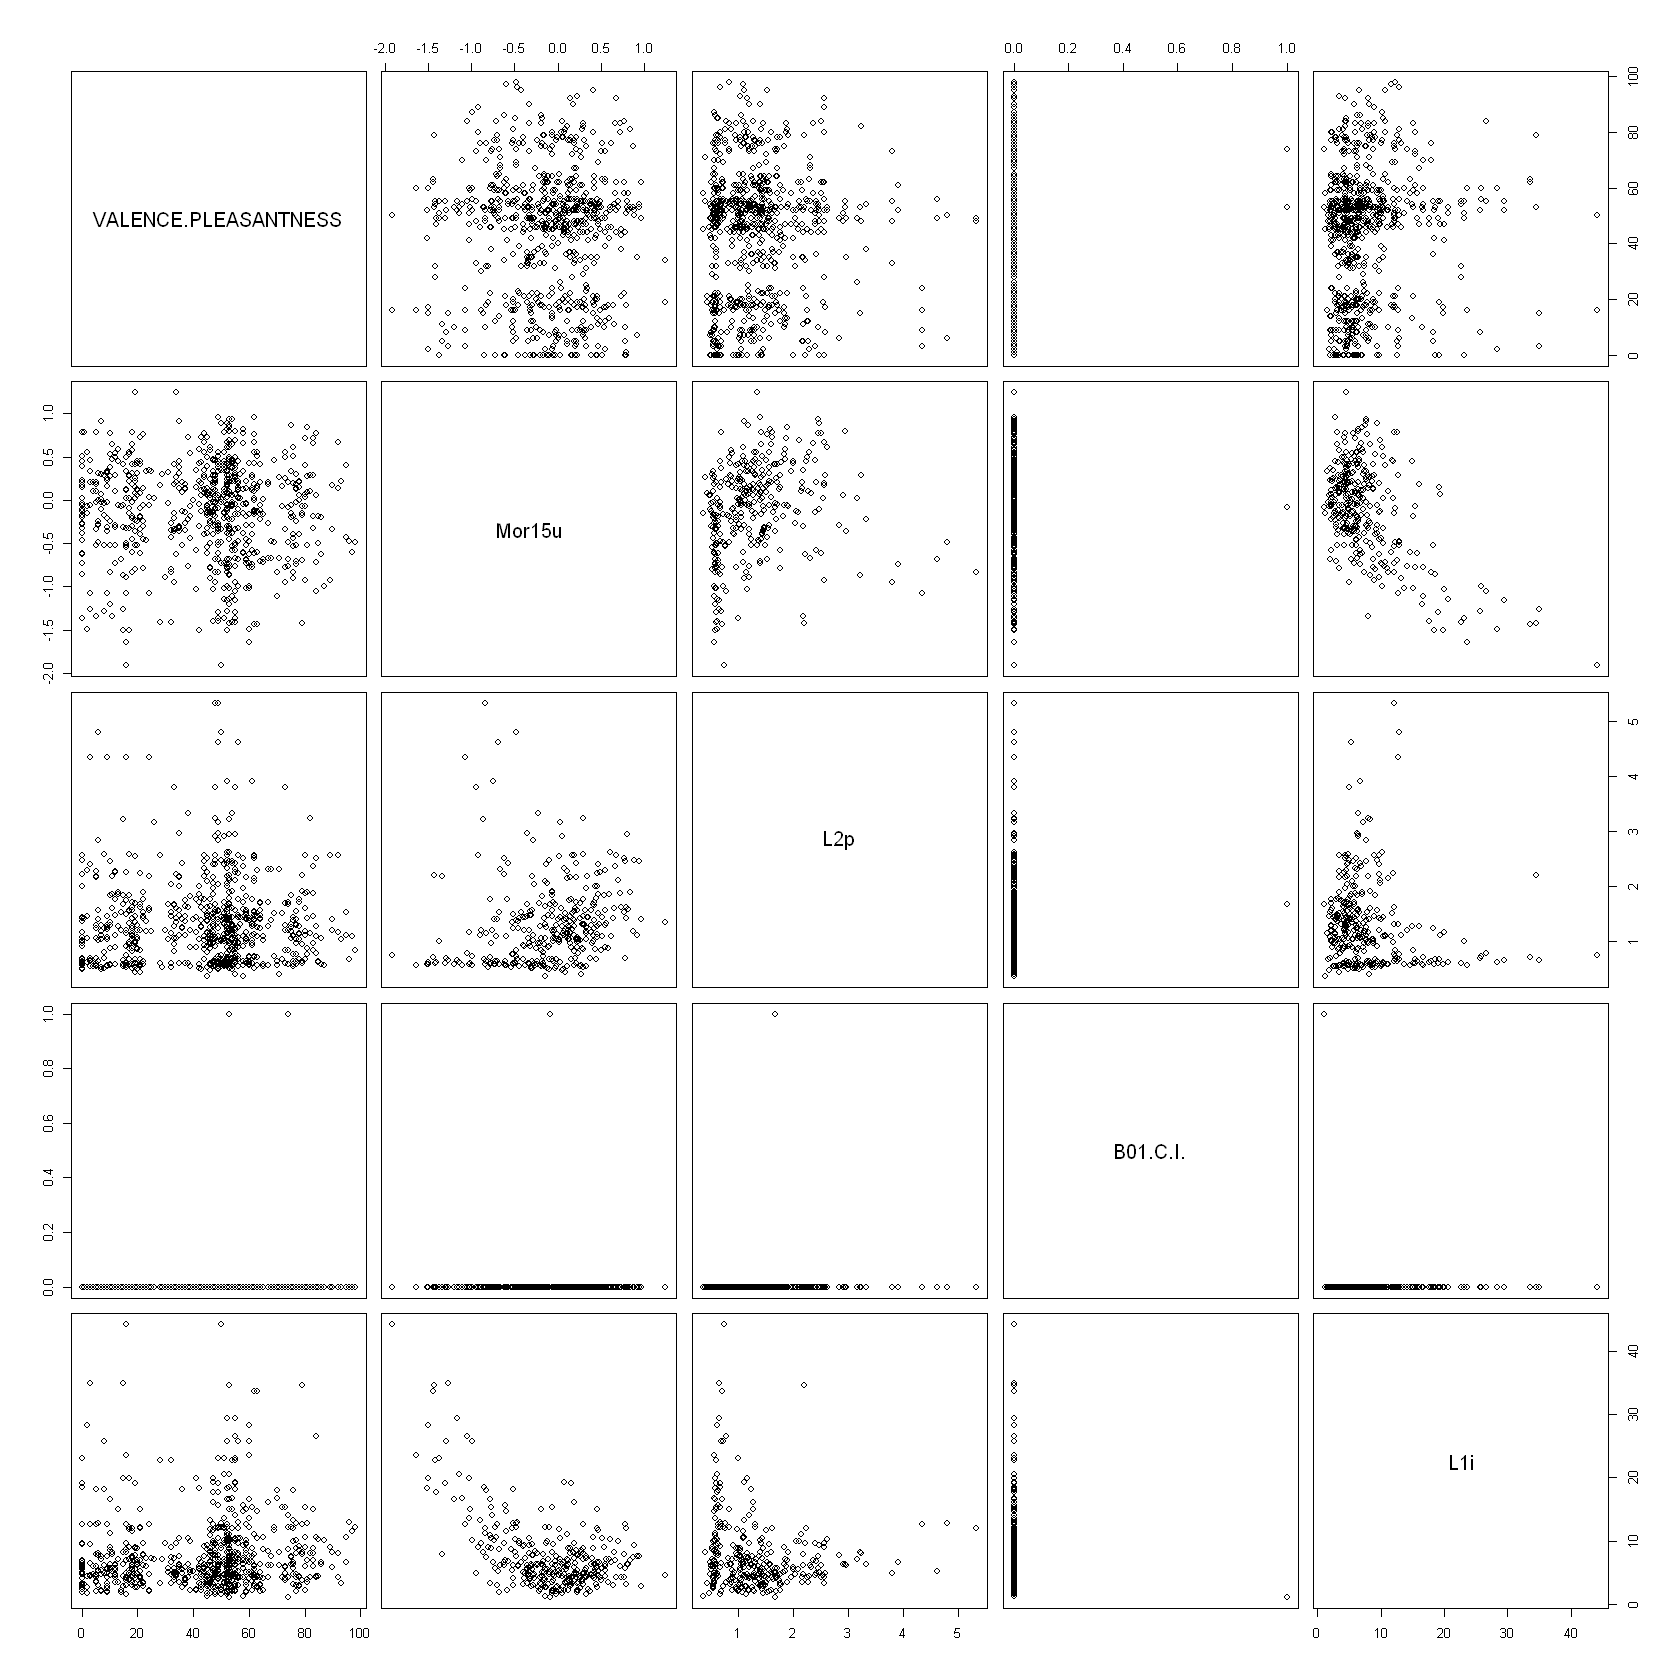

In [68]:
options(repr.plot.width=14, repr.plot.height=14)
par(mfrow=c(2,2))
set.seed(56)
pairs(data[c(1,sample(1:ncol(data),4))],cex.labels=1.5)

# 2. linear regression

Let's firstly split the data in a training and test set (test set on kaggle is for later)

In [69]:
idx.train<-sample(nrow(data), nrow(data)*(2/3)) #2/3 taken into the training set because it will later be splitted again to get a validation set
data.train<-data[idx.train,]
data.test<-data[-idx.train,]
dim(data.train)
dim(data.test)

[1]  472 3033

[1]  236 3033

Now let's run a simple linear regression on the whole training set. The result will be bad, since p>n it will largely overfit the data, but this result will serve us as baseline for the rest. 

In [9]:
basic.lin.fit<-lm(VALENCE.PLEASANTNESS ~ ., data.train)

In [11]:
train.pred<-predict(basic.lin.fit,data.train)
test.pred<-predict(basic.lin.fit, data.test)
train.MSE<-mean((data.train$VALENCE.PLEASANTNESS-train.pred)^2)
test.MSE<-mean((data.test$VALENCE.PLEASANTNESS-test.pred)^2)
cat("train MSE: ", train.MSE,"\n", "test MSE: ", test.MSE)

Warning message in predict.lm(basic.lin.fit, data.train):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(basic.lin.fit, data.test):
"prediction from a rank-deficient fit may be misleading"


train MSE:  96.95045 
 test MSE:  4.637953e+20

We can se the huge test error, coming from the largely overfitting model. 

We are in the situation n<p, we have to find the best number of relevant predictors using 5-fold cross-validation on forward subsetting (best subset selection will ask to much computing):

In [73]:
library(leaps)
library(tidymodels)

In [76]:
predict.regsubsets <- function(object, newdata, id, form = as.formula(object$call[[2]])) {
    mat = model.matrix(form, newdata)
    coefi = coef(object, id=id)
    xvars = names(coefi)
    mat[,xvars]%*%coefi
}                                    #using predict formula defined in Lecture 4

In [78]:
fit.and.eval<-function(fold,formula = VALENCE.PLEASANTNESS ~ .) {
    fit<-regsubsets(formula, analysis(fold), nvmax=30, method = 'forward')
    valid.set<-assessment(fold)
    sapply(1:(fit$nvmax-1),
          function(nb) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, nb, formula))^2))
}
validation.data<-vfold_cv(data,v=5)
cv.errors<-sapply(validation.data$splits, fit.and.eval)
head(cv.errors)


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2710  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2711  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2708  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2712  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"2709  linear dependencies found"


Reordering variables and trying again:


253.2524,350.4810,295.1347,349.3675,329.1570
256.7313,358.4596,280.5217,351.1872,322.3044
256.5084,367.3672,319.5868,349.1995,324.1539
262.6435,362.4751,326.9709,355.6666,325.4438
263.9150,358.9280,318.6749,344.6454,318.3929
257.9440,357.2943,307.0730,335.7402,307.3385


In [82]:
head(cv.errors,10)
which.min(rowMeans(cv.errors))

253.2524,350.4810,295.1347,349.3675,329.1570
256.7313,358.4596,280.5217,351.1872,322.3044
256.5084,367.3672,319.5868,349.1995,324.1539
262.6435,362.4751,326.9709,355.6666,325.4438
263.9150,358.9280,318.6749,344.6454,318.3929
257.9440,357.2943,307.0730,335.7402,307.3385
255.4004,356.0790,314.7202,336.8180,302.0043
265.9355,363.2667,311.2241,331.1116,301.1186
263.6568,360.2667,316.6011,333.9795,299.3935
266.3011,360.9370,323.9093,336.1302,303.3486


[1] 7